# Power anaylysis

Write some code to play with the analysis shown in Fig. 1 of: Button et al (2013), Power failure: why small sample size undermines the reliability of neuroscience, Nature Reviews Neuroscience.

From the legend: 

Statistical power of a replication study. a | If a study finds evidence for an effect at p=0.05, then the difference between the mean of the null distribution (indicated by the solid blue curve) and the mean of the observed distribution (dashed blue curve) is 1.96×sem. b | Studies attempting to replicate an effect using the same sample size as that of the original study would have roughly the same sampling variation (that is, sem) as in the original study. Assuming, as one might in a power calculation, that the initially observed effect we are trying to replicate reflects the true effect, the potential distribution of these replication effect estimates would be similar to the distribution of the original study (dashed green curve). A study attempting to replicate a nominally significant effect (p~0.05), which uses the same sample size as the original study, would therefore have (on average) a 50% chance of rejecting the null hypothesis (indicated by the coloured area under the green curve) and thus only 50% statistical power. c | We can increase the power of the replication study (coloured area under the orange curve) by increasing the sample size so as to reduce the sem. Powering a replication study adequately (that is, achieving a power ?80%) therefore often requires a larger sample size than the original study, and a power calculation will help to decide the required size of the replication sample.

Copyright 2020 by Joshua I. Gold


In [1]:
import platform

# Output on system used for development/testing:
# 3.9.2
print(platform.python_version())

# Uncomment and run to clear workspace
# %reset


3.9.2


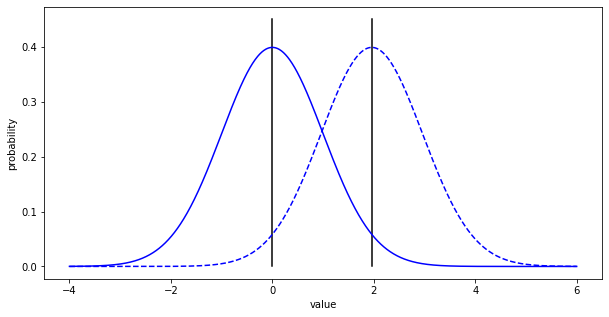

5030 positive outcomes out of 10000 experiments (50.30 pct)


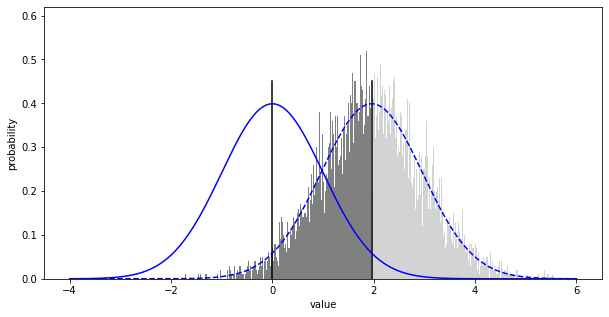

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# Assume that an original study identified an effect size, representing the difference in the mean value of a test distribution versus a null distribution, divided by their common standard deviation (i.e., the z-score of their difference), at exactly p=0.05. Remember that these are distributions of mean values, so the standard deviations of these distributions represent standard errors of the mean. For a two-tailed test, this p-value implies that 0.975 of the area of the null distribtion is less than the effect size:
effect_size = st.norm.ppf(0.975)

# We can now reproduce the first panel:
plt.figure(figsize=(10, 5))
mu_0 = 0
sem = 1      # make it easy by assuming sem=1
mu_1 = effect_size*sem
bin_size = 0.01
x_axis = np.arange(-4, 6+bin_size, bin_size)
x_edges = np.arange(x_axis[0]-bin_size/2, x_axis[-1]+bin_size, bin_size)
plt.plot([mu_0, mu_0], [0, 0.45], 'k-')
plt.plot([mu_1, mu_1], [0, 0.45], 'k-')
plt.plot(x_axis, st.norm.pdf(x_axis, mu_0, sem), 'b-')
plt.plot(x_axis, st.norm.pdf(x_axis, mu_1, sem), 'b--')
plt.xlabel('value')
plt.ylabel('probability')
plt.show()

# Now what happens when we try to replicate the result under the exact same conditions? Let's simulate N experiments:
N = 10000

# In each simulated experiment, we end up with a mean value that comes from the experimental distribution, and we only reject the Null hypothesis if the value is greater than or equal to the previous effect size:
outcomes = np.random.normal(mu_1, sem, N)
outcome_is_positive = outcomes >= effect_size
print(f'{np.count_nonzero(outcome_is_positive)} positive outcomes out of {N} experiments ({np.count_nonzero(outcome_is_positive)/N*100:.2f} pct)')

# We can plot these results as a normalized histogram
counts_no_effect, _ = np.histogram(outcomes[np.logical_not(outcome_is_positive)], bins=x_edges)
counts_effect, _    = np.histogram(outcomes[outcome_is_positive], bins=x_edges)
counts_all, _       = np.histogram(outcomes, bins=x_edges)
normalizer          = np.trapz(counts_all, dx=bin_size)

# Plot it
plt.figure(figsize=(10, 5))
plt.bar(x_axis, counts_no_effect/normalizer, width=0.01, color='gray')
plt.bar(x_axis, counts_effect/normalizer, width=0.01, color='lightgray')
plt.plot([mu_0, mu_0], [0, 0.45], 'k-')
plt.plot([mu_1, mu_1], [0, 0.45], 'k-')
plt.plot(x_axis, st.norm.pdf(x_axis, mu_0, sem), 'b-')
plt.plot(x_axis, st.norm.pdf(x_axis, mu_1, sem), 'b--')
plt.xlabel('value')
plt.ylabel('probability')
plt.show()

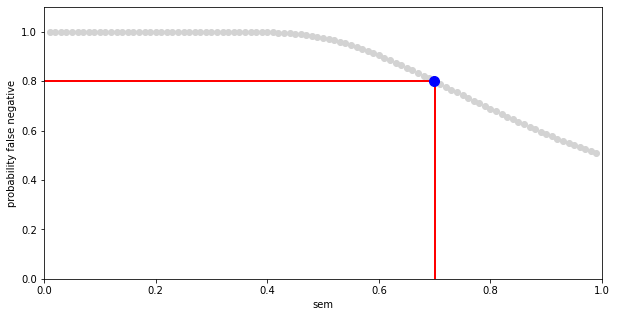

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# We can increase the power by increasing the signal-to-noise ratio (SNR) of our sample, via a reduction in sem and assuming the same mean effect size. The figure in the paper is confusing, because increasing SNR would narrow *both* distributions (because we assume that the two hypotheses differ only by their mean value, not the STD of the distributions). It is the change in both distributions that explains why you would be less likely to reject the Null hypothesis for the same effect size under these conditions.
#
# Also note that sem depends on both the number of samples (N) and the STD of the sampled distribution, so we need to define N or STD to be able to express sem in terms of the other of those two values.

# We can use a power analysis to find the new sem. The key point is that a power analysis describes a relationship between the effect size and the power -- so we can define a particular power to compute the effect size. In this case, this computation is equivalent to doing a z test with one sample and a power of 80%, which can be computed as follows (which is basically computing: what is the mean of a standard normal distribution that has 80% of its mass >= the cutoff for the null distribution at z=0.975?)
power = 0.8
new_effect_size = st.norm.ppf(0.975) - st.norm.ppf(1-power)

# This effect size is again the z-score, given the same mean difference as above and the new sem -- so we can use it to compute the new sem:
old_effect_size = st.norm.ppf(0.975)
old_sem = 1
mu_0 = 0
mu_1 = effect_size*old_sem
new_sem = (mu_1-mu_0)/new_effect_size

# To show that this is the case, let's try a bunch of sems and find the value that corresponds to when 80% of the effect distribution is >= the p=0.05 cutoff for the null distribution

# Try a bunch of sems, smaller than before (i.e., <1)
sems = np.arange(0.01, 1, 0.01)
vals = np.zeros(np.size(sems))

# Loop through them
for idx, val in enumerate(sems):
   
   # The probability of not rejecting the null hypothesis when the null hypothesis is false is the mass of the effect distribution, which still has a mean value of effectSize but now has the given sem, that is to the right of the new cutoff
   new_cutoff = st.norm.ppf(0.975, mu_0, val)
   vals[idx] = 1 - st.norm.cdf(new_cutoff, effect_size, val) 

# Plot it
plt.figure(figsize=(10, 5))
plt.plot(sems, vals, 'o', color='lightgray')
val_indices = np.flatnonzero(vals<=0.8)
new_sem2 = sems[val_indices[0]]
plt.plot([new_sem2, new_sem2], [0, 0.8], 'r-', linewidth=2)
plt.plot([0, new_sem2], [0.8, 0.8], 'r-', linewidth=2)
plt.plot(new_sem, 0.8, 'bo', markerfacecolor='b', markersize=10)
plt.xlabel('sem')
plt.ylabel('probability false negative')
plt.axis([0, 1, 0, 1.1])
plt.show()


8048 positive outcomes out of 10000 experiments (80.48 pct)


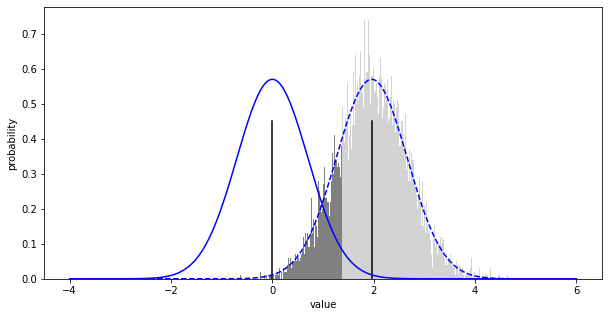

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# Now do the simulated experiments as above, but with the new distributions
N = 10000
power = 0.8
new_effect_size = st.norm.ppf(0.975) - st.norm.ppf(1-power)
old_sem = 1
mu_0 = 0
mu_1 = effect_size*old_sem
new_sem = (mu_1-mu_0)/new_effect_size

bin_size = 0.01
x_axis = np.arange(-4, 6+bin_size, bin_size)
x_edges = np.arange(x_axis[0]-bin_size/2, x_axis[-1]+bin_size, bin_size)

outcomes = np.random.normal(mu_1, new_sem, N)
outcome_is_positive = outcomes >= st.norm.ppf(0.975, mu_0, new_sem)
print(f'{np.count_nonzero(outcome_is_positive)} positive outcomes out of {N} experiments ({np.count_nonzero(outcome_is_positive)/N*100:.2f} pct)')

# We can plot these results as a normalized histogram
counts_no_effect, _ = np.histogram(outcomes[np.logical_not(outcome_is_positive)], bins=x_edges)
counts_effect, _    = np.histogram(outcomes[outcome_is_positive], bins=x_edges)
counts_all, _       = np.histogram(outcomes, bins=x_edges)
normalizer          = np.trapz(counts_all, dx=bin_size)

# Plot it
plt.figure(figsize=(10, 5))
plt.bar(x_axis, counts_no_effect/normalizer, width=0.01, color='gray')
plt.bar(x_axis, counts_effect/normalizer, width=0.01, color='lightgray')
plt.plot([mu_0, mu_0], [0, 0.45], 'k-')
plt.plot([mu_1, mu_1], [0, 0.45], 'k-')
plt.plot(x_axis, st.norm.pdf(x_axis, mu_0, new_sem), 'b-')
plt.plot(x_axis, st.norm.pdf(x_axis, mu_1, new_sem), 'b--')
plt.xlabel('value')
plt.ylabel('probability')
plt.show()


In [ ]:
%whos